<a href="https://www.kaggle.com/code/mcpenguin/ps3e22-eda-fe-prediction?scriptVersionId=143234720" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

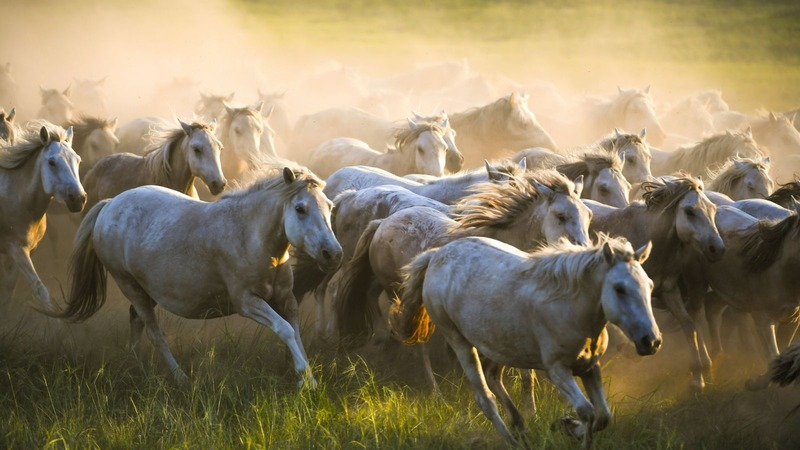

*Image source: National Geographic. [Link](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.nationalgeographic.co.uk%2Fanimals%2F2021%2F10%2Fdomestic-horses-mysterious-origins-may-finally-be-revealed&psig=AOvVaw3Yq3Omt5s23_MEVJ0fKIg8&ust=1694566133386000&source=images&cd=vfe&opi=89978449&ved=0CBIQjhxqFwoTCICYp_Xso4EDFQAAAAAdAAAAABAE)*

# Season 3 Episode 22 Playground Competition: EDA + Feature Engineering + Prediction

This notebook provides some EDA of the data for the S3E22 playground competition, where our goal is to predict the eventual health status of horses given various health indicators. We will then build a predictive model to classify the horses' health status.

I will be regularly updating this notebook over the coming days. If you think I missed any key analyses, I would be grateful if you could leave them in the Discussion section :)

# Global Configuration Parameters

By setting global configuration parameters at the start of the notebook, we are able to easily tweak hyperparameters to see how they influence the training time, our model's performance on the training/test sets, and so on.

In [ ]:
global_seed = 42

class CONFIG:
    
    # whether to show graphs in this notebook
    # useful to hide output for brevity
    show_graphs = True
    
    # number of trials for training
    training_num_trials = 5000
    
    # number of folds to use for cross-validation
    num_fold = 10
    
    # boosting model parameters
    boosting_params = {
        'num_leaves': 31, 
        'max_depth': 4,
        'n_estimators': 1000,
        'objective': 'multiclass', 
        'num_class': 3,
        'random_state': global_seed,
        'verbose': -1,
    }

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import lightgbm as lgb

## Stylistic Configuration

In [ ]:
sns.set_style("whitegrid")
pd.set_option("display.max_columns", False)

# Import Data

We will augment our data with the original dataset. However, since that dataset does not contain an `id` field, we will need to artificially augment that dataset with one before concatenating it to our dataset.

In [ ]:
INPUT_DIR = "/kaggle/input/playground-series-s3e22"

df_train_1 = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))

df_train_2 = pd.read_csv("/kaggle/input/horse-survival-dataset/horse.csv")
df_train_2["id"] = df_train_1.shape[0] + df_test.shape[0] + df_train_2.index
df_train = pd.concat([df_train_1, df_train_2])
df_train = df_train.reset_index().drop(columns=["index"])

df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, "sample_submission.csv"))

## Initial Look into Data

Let's see how the data looks like:

In [ ]:
df_train.head()

In [ ]:
df_test.head()

## Column Information

From [this discussion post](https://www.kaggle.com/competitions/playground-series-s3e22/discussion/438603) we can trace the source of the [original dataset on Kaggle](https://www.kaggle.com/datasets/yasserh/horse-survival-dataset). The same discussion post gives some background to the variates as well, which I will paraphrase here. Please go upvote the original discussion post!

- `surgery`: Whether the horse has had surgery (yes/no).
- `age`: The age of the horse (adult/young).
    - In this case, a horse is considered *young* if its age is less than 6 months.
- `hospital number`: A numeric ID representing the case number assigned to the horse.
    - This may not be unique if the horse is treated more than 1 time.
- `rectal_temp`: The rectal temperature of the horse, in degrees Celsius.
    - An elevated temperature may occur to infection.
- `respiratory_rate`: The number of breaths per minute.
- `temp_of_extremities`: A subjective measurement of the temperature of the horse's extremities.
    - This has possible values of Warm, Normal, Cool or Cold.
- `peripheral_pulse`: A subjective measurement of the temperature of the horse's peripheral pulse.
    - This has possible values of Normal, Increased, Reduced and Absent.
- `mucous_membrane`: A subjective measurement of the color of the horse's mucus membrane.
    - This has possible values of normal pink, bright pink, pale pink, pale cyanotic, bright red, dark cyanotic.
    - Normal/bright pink may indicate normal/slightly increased circulation.
    - Pale pink may happen in early shock
    - Pale/dark cyanotic may indicate serious circulatory compromise.
    - Bright red is more indicative of septicemia.
- `capillary_refill_time`: A clinical judgement of how long it takes for the capillaries to refill.
    - This is classified by < 3 seconds, = 3 seconds, or > 3 seconds.
- `pain`: A subjective measurement of the pain the horse is experiencing.
    - Can have values of alert, no pain, depressed, slight pain, severe pain, or extreme pain.
    - The more painful the animal is, the greater the likelihood surgery is needed
    - Note that the prior treatment of pain can mask the pain level to some extent
- `peristalsis`: An indication of activity in the horse's gut.
    - Possible values of Hypermotile, Normal, Hypomotile, Absent
    - As the gut becomes more distended or toxic, the activity decreases
- `abdominal_distention`: An indication of swelling of the abdomen.
    - Possible values of None, Slight, Moderate and Severe
    - An animal with abdominal distention is more likely to have pain and reduced gut mobility.
- `nasogastric_tube`: A qualitative measurement of the amount of gas coming out of the horse.
    - Possible values of None, Slight and Significant
    - A large gas cap in the horse is more likely to give the horse discomfort.
- `nasogastric_reflux`: A quantitative measurement of the amount of reflux coming out of the horse.
    - Possible values of None, Slight, < 1 Liter and > 1 Liter
    - The greater the amount of reflux, the more likely there is some serious obstruction to the fluid passage from the rest of the intestine.
- `nasogastric_reflux_ph`: A quantitative measurement of the pH of the nasogastric reflux, from 0 to 14.
- `rectal_exam_feces`: A measurement of how many feces were present in the rectal exam.
    - Possible values of Normal, Increased, Decreased and Absent
- `abdomen`: A measurement of the state of the horse's abdomen.
    - Possible values of Normal, Other, Firm Feces, Distended Small Intestine, and Distended Large Intestine
    - Firm Feces may indicate a mechanical impaction and is normally treatable by conventional medical means
    - Distended Small/Large Intestines may indicate a surgical lesion
- `packed_cell_volume`: The number of red blood cells in the horse's blood.
    - This increases as the circulation becomes compromised or as the animal becomes dehydrated.
- `total_protein`: The total concentration of protein in the horse's blood.
- `abdomo_appearance`: A measurement of the fluid obtained from the horse's abdominal cavity when a needle is put in the horse's abdomen.
    - Possible values of Clear, Cloudy and Serosanguinous
    - Normal fluid is clear
    - Serosanguinous fluid indicates a compromised gut
- `surgical_lesion`: Retrospectively, was the problem (lesion) surgical? (yes/no)
    
We are trying to predict the following response:

- `outcome`: What eventually happened to the horse: died, was euthanized, or lived

## Initial Information About Data

We can get some information about the data using the `info` and `describe` commands. In particular, we are concerned about

- the shape of the data;
- the amount of missing values;
- some numerical summaries about the variates (e.g. mean, number of unique elements, etc)

In [ ]:
df_train.info()

In [ ]:
df_test.info()

As we can see, some of the variates contain missing values. We will need to figure out the best way of "filling in the gaps".

We can also get an initial sense of the distributions of the data:

In [ ]:
df_train.describe(include=[np.number]).T

In [ ]:
df_train.describe(exclude=[np.number]).T

In [ ]:
df_test.describe(include=[np.number]).T

In [ ]:
df_test.describe(exclude=[np.number]).T

# Exploratory Data Analysis

We are now ready to perform some EDA on this dataset. This will help us better understand the distributions of the data features and relationships between them, as well as detect any anomalies that we can account for before beginning modelling.

## Distributions of Individual Variates

We can use countplots and histograms to get a sense of the distributions of the individual categorical and numerical variates respectively.

For the training set, we further subdivide the feature distributions between the different response classes.

In [ ]:
# helper function to add margin to plot
# source: https://stackoverflow.com/questions/34187970/setting-margins-in-matplotlib-seaborn-with-subplots
def add_margin(ax,x=0.05,y=0.05):
    # This will, by default, add 5% to the (top of) x and y margins. You 
    # can customise this using the x and y arguments when you call it.

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1]-xlim[0])*x
    ymargin = (ylim[1]-ylim[0])*y

    ax.set_xlim(xlim[0], xlim[1]+xmargin)
    ax.set_ylim(ylim[0], ylim[1]+ymargin)

In [ ]:
# maintain a dictionary for the order of columns
# this will be useful for label encoding our features
categorical_cols_order_dict = {
    "surgery": ["yes", "no"],
    "age": ["young", "adult"],
    "temp_of_extremities": ["warm", "normal", "cool", "cold"],
    "peripheral_pulse": ["absent", "reduced", "normal", "increased"],
    "mucous_membrane": ["dark_cyanotic", "pale_cyanotic", "pale_pink", "normal_pink",
                       "bright_pink", "bright_red"],
    "capillary_refill_time": ["less_3_sec", "3", "more_3_sec"],
    "pain": ["depressed", "slight", "moderate", "alert", "mild_pain", "severe_pain", "extreme_pain"],
    "peristalsis": ["hypermotile", "normal", "hypomotile", "absent", "distend_small"],
    "abdominal_distention": ["none", "slight", "moderate", "severe"],
    "nasogastric_tube": ["none", "slight", "significant"],
    "nasogastric_reflux": ["none", "slight", "less_1_liter", "more_1_liter"],
    "rectal_exam_feces": ["absent", "decreased", "normal", "increased", "serosanguious"],
    "abdomen": ["normal", "firm", "distend_small", "distend_large", "other"],
    "abdomo_appearance": ["clear", "cloudy", "serosanguious"],
    "surgical_lesion": ["yes", "no"],
    "cp_data": ["yes", "no"],
    "outcome": ["lived", "euthanized", "died"]
}

numeric_cols = df_train.select_dtypes(include=[np.number])
categorical_cols = df_train.select_dtypes(exclude=[np.number])
response_col = "outcome"

In [ ]:
%%time
if CONFIG.show_graphs:
    
    fig, axes = plt.subplots(nrows=len(df_train.columns), ncols=2,
                            figsize=(18, len(df_train.columns)*5))
    plt.subplots_adjust(hspace=0.3)

    pbar = tqdm(list(enumerate(df_train.columns)))
    for row_idx, col in pbar:
        pbar.set_postfix(col=col)
        if col in numeric_cols:
            sns.histplot(data=df_train, x=col, ax=axes[row_idx][0], 
                         hue=response_col, multiple="stack",
                        hue_order=categorical_cols_order_dict[response_col])
            sns.histplot(data=df_test, x=col, ax=axes[row_idx][1])
        else:
            order = categorical_cols_order_dict[col]
            if col == response_col:
                hue = None
                hue_order = None
            else:
                hue = response_col
                hue_order = categorical_cols_order_dict[response_col]
                
            sns.countplot(data=df_train, x=col, ax=axes[row_idx][0],
                         order=order, hue=hue, hue_order=hue_order)
            if col != response_col:
                sns.countplot(data=df_test, x=col, ax=axes[row_idx][1],
                             order=order)

            for col_idx in [0,1]:
                ax = axes[row_idx][col_idx]
                # add some margin on top of the countplot
                # so count doesn't get "squashed"
                add_margin(ax, x=0, y=0.1)

                # show count on top of countplots
                if col_idx != 1 or col != response_col:
                    for container in ax.containers:
                        ax.bar_label(container)

        axes[row_idx][0].set_title(f"{col} in training set")
        axes[row_idx][1].set_title(f"{col} in test set")

    plt.show()  
    
else:
    print("INFO: CONFIG.show_graphs is False, omitting display of graphs")

We see that the distributions of the variates are fairly similar between the training and test sets. However, there are some variates where one property dominates the other; we will need to be careful in handling these when modelling to make sure we do not "overfit" to the training data.

## Investigating Hospital Number

One variate that seems to look weird on our histogram plot is the hospital number. Let's take a look at the unique values for this feature in our training and test datasets:

In [ ]:
df_train["hospital_number"].unique()

In [ ]:
df_test["hospital_number"].unique()

From this, we see that the hospital numbers list has two "categories":
- one where the number is around 500K; and
- one where the number is around 5M.

Knowing this, we can make a better plot for the distribution of the training dataset's hospital numbers by plotting these two categories separately.

In [ ]:
if CONFIG.show_graphs:
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.histplot(data=df_train[df_train["hospital_number"] // 100000 == 5], x="hospital_number", ax=axes[0])
    axes[0].set(title=f"Hospital Numbers for ID ~500K")

    sns.histplot(data=df_train[df_train["hospital_number"] // 100000 == 52], x="hospital_number", ax=axes[1])
    axes[1].set(title=f"Hospital Numbers for ID ~5M")

    plt.show()
else:
    print("INFO: CONFIG.show_graphs is False, omitting display of graphs")

# Feature Engineering

We are now ready to engineer features that we will use in our modelling.

## Filling In Missing Values

Let's first check which features contain missing values in the training and test datasets.

In [ ]:
missing_cols_train = df_train.isna().sum()[lambda x: x>0]
missing_cols_train

In [ ]:
missing_cols_test = df_test.isna().sum()[lambda x: x>0]
missing_cols_test

We see that both the training and test sets have missing values, but the columns in which they have missing values are consistent.

We will fill in the missing values using the following strategy:

- For categorical columns, we will fill in the values using the most frequent category (aka the mode);
- For numerical columns, we will impute the values using a K-Nearest Neighbors algorithm.

In [ ]:
for col in missing_cols_train.index:
    if df_train[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        imputer = KNNImputer(n_neighbors = 5)
        df_train[col] = imputer.fit_transform(df_train[col].values.reshape(-1, 1))
        df_test[col] = imputer.fit_transform(df_test[col].values.reshape(-1, 1))
    else:
        df_train[col] = df_train[col].fillna(df_train[col].mode().iloc[0])
        df_test[col] = df_test[col].fillna(df_test[col].mode().iloc[0])

We can verify that there are no more missing values in our datasets now:

In [ ]:
df_train.isna().sum()[lambda x: x>0]

In [ ]:
df_test.isna().sum()[lambda x: x>0]

## Converting Rectum Temperature to "Deviation"

We will convert temperature to `|T - 37.8|`. The reasoning behind this is that the higher the absolute difference, the worse it is. See [this discussion post](https://www.kaggle.com/competitions/playground-series-s3e22/discussion/438680) for more information.

In [ ]:
df_train["abs_rectal_temp"] = (df_train["rectal_temp"] - 37.8).abs()
df_test["abs_rectal_temp"] = (df_test["rectal_temp"] - 37.8).abs()

df_train = df_train.drop(columns=["rectal_temp"])
df_test = df_test.drop(columns=["rectal_temp"])

## One-Hot/Label Encoding of Categorical Features

To convert our categorical features into numeric ones, we will encode them using ordinal and one-hot encodings. We note that we will an ordinal encoding of the feature is only appropriate if the data can be ordered; otherwise, a one-hot encoding would be more appropriate.

For ordinal encodings, we can re-use the same "orders" that we used to plot the feature distributions in our EDA.

We will also store the (fitted) encoders in a dictionary for later use in the modelling, training and predictive steps.

In [ ]:
one_hot_cols = ['pain', 'abdomen', 'mucous_membrane', 'abdomo_appearance']
ordinal_cols = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'capillary_refill_time', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'surgical_lesion',
       'cp_data']

# [col]: encoder 
encoders_dict = {}

# encode one-hot columns
for col in one_hot_cols:
    vals = [ categorical_cols_order_dict[col] ]
    enc = OneHotEncoder(categories = vals, sparse_output = False)
    enc_cols = [f"{col}_{val}" for val in vals[0]]
    
    train_transformed = enc.fit_transform(df_train[col].values.reshape(-1, 1))
    test_transformed = enc.transform(df_test[col].values.reshape(-1, 1))
    
    train_ohedf = pd.DataFrame(train_transformed, columns=enc_cols)
    test_ohedf = pd.DataFrame(test_transformed, columns=enc_cols)
    
    df_train = pd.concat([df_train, train_ohedf], axis=1).drop(columns=[col])
    df_test = pd.concat([df_test, test_ohedf], axis=1).drop(columns=[col])
    
    encoders_dict[col] = enc

# encode ordinal columns
for col in ordinal_cols:
    vals = [ categorical_cols_order_dict[col] ]
    enc = OrdinalEncoder(categories = vals)
    df_train[col] = enc.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = enc.transform(df_test[col].values.reshape(-1, 1))
    
    encoders_dict[col] = enc
    
# encode response column
vals = [ categorical_cols_order_dict[response_col] ]
enc = OrdinalEncoder(categories = vals)
df_train[response_col] = enc.fit_transform(df_train[response_col].values.reshape(-1, 1))
encoders_dict[response_col] = enc

## Viewing The Transformed Data

We can now see how our data looks like after all our feature engineering.

In [ ]:
df_train.head()

## Correlation Matrix

Using the new label encoded features, we can now plot the correlation matrix for all our features in the training dataset.

In [ ]:
plt.figure(figsize=(30, 30))

ax = sns.heatmap(df_train.corr(numeric_only=True), cmap="crest")
plt.show()

# Modelling & Training

We are now ready to begin modelling and training. We will be using a LGBM classifier with k-fold cross validation. Note that the parameters for the model are defined at the start of the notebook in our global configuration, so that we do not have to "scroll all the way down" to modify the training parameters.

## Split Data Into K-Folds

We will first split our data into numerous folds using stratified K-fold sampling by the `outcome` response variate.

In [ ]:
X_train = df_train.drop(columns=[response_col])
y_train = df_train[response_col]
skf = StratifiedKFold(n_splits=CONFIG.num_fold, shuffle=True, random_state=global_seed)

for i, (_, val_index) in enumerate(skf.split(X_train, y_train)):
    df_train.loc[val_index, "fold"] = i

df_train.head()

# Training

We can now commence training, using the stratified k-fold cross-validation. We will store the trained models in a dictionary so that we can use them later.

In [ ]:
# [fold]: trained model
models_dict = {}

for fold in range(CONFIG.num_fold):
    print("-"*25)
    print(f"Training for FOLD {fold}")
    print("-"*25)
    
    train_data = df_train[df_train["fold"] != fold]
    valid_data = df_train[df_train["fold"] == fold]
    
    X_training = train_data.drop(columns=[response_col, "fold"])
    y_training = train_data[response_col]
    
    X_val = valid_data.drop(columns=[response_col, "fold"])
    y_val = valid_data[response_col]
    
    train_ds = lgb.Dataset(X_training, label=y_training)
    valid_ds = lgb.Dataset(X_val, label=y_val)
    
    evaluation_results = {}
    model = lgb.train(
        params = CONFIG.boosting_params,
        train_set = train_ds,
        num_boost_round = CONFIG.training_num_trials,
        valid_sets = valid_ds,
        callbacks = [
            lgb.early_stopping(stopping_rounds=30, verbose=True),
            lgb.log_evaluation(50),
            lgb.callback.record_evaluation(evaluation_results)
    ])
    
    models_dict[fold] = model

# Evaluation

We can evaluate the k-fold models on the training set. To do this, for each "fold model", we will predict the values of its corresponding validation set. We can then compute metrics about these predictions.

## Micro-F1 Score (competition metric)

We can first calculate the micro-F1 score, which is given as the metric for this competition.

In [ ]:
trues = []
preds = []

for fold, model in models_dict.items():
    
    valid_data = df_train[df_train["fold"] == fold]
    X_val = valid_data.drop(columns=[response_col, "fold"])
    y_val = valid_data[response_col]
    
    true = y_val
    pred = model.predict(X_val).argmax(axis=1)
    
    trues.extend(true)
    preds.extend(pred)

preds = np.asarray(preds)
trues = np.asarray(trues)

pred_labels = encoders_dict[response_col].inverse_transform(preds.reshape(-1, 1))
true_labels = encoders_dict[response_col].inverse_transform(trues.reshape(-1, 1))

micro_f1_score = f1_score(true_labels, 
                          pred_labels,
                         average='micro')
print(f"Micro F1 score: {micro_f1_score}")

## Classification Report

We can next print the classification report for our model.

In [ ]:
print(classification_report(true_labels, pred_labels))

## Confusion Matrix

Lastly, we can display the confusion matrix for our model. This tells us the frequencies at which our model predicted a certain category another category in a matrix form.

In [ ]:
conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,8))
ax = sns.heatmap(conf_matrix, annot=True, 
                 xticklabels=encoders_dict[response_col].categories_[0],
                yticklabels=encoders_dict[response_col].categories_[0])
plt.show()

# Prediction

We can now use our models to predict the outcome values for the test set, and use this as our submission. In particular, we will use the mean of all the class probabilities for the data in the test set predicted by each model.

In [ ]:
# list of predictions for each fold
preds_folds = []

for fold, model in models_dict.items():
    print(f"Predicting for FOLD {fold}")
    
    pred_probs = model.predict(df_test)
    preds_folds.append(pred_probs)

preds_folds = np.asarray(preds_folds)
preds_avg = preds_folds.mean(axis=0)
preds = preds_avg.argmax(axis=1)
preds_labels = encoders_dict[response_col].inverse_transform(preds.reshape(-1, 1))

df_test[response_col] = preds_labels.reshape(-1)

In [ ]:
df_test.head()

# Submission

In [ ]:
df_test[["id", response_col]].to_csv("submission.csv", index=False)

# Thanks for reading!